## Chapter 3 [Imaging](Ch3-Imaging.ipynb)


<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Analysis


part of 

## [Analysis of Transmission Electron Microscope Data](_Analysis_of_Transmission_Electron_Microscope_Data.ipynb)



by Gerd Duscher, 2019

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes
part of 


## First we import all relvant libraries

In [1]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive plots
%pylab --no-import-all inline 

#notebook

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh
# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
import pyTEM.TEMlib.KinsCat as ks         # Kinematic sCattering Library


# The file format we use is pyUSID
import pyUSID as usid
import h5py as hf5

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyUSID version: ',usid.__version__)
print('pyTEM version: ',pyTEMlib.__version__)

%gui qt

Populating the interactive namespace from numpy and matplotlib
windows
Using KinsCat library version  0.5  by G.Duscher
Symmetry functions of spglib enabled
pyUSID version:  0.0.4
pyTEM version:  0.3.2019


# Load an atomic resolution image
As an example we will use **p1-hr3-ZnOonGraphite.dm3** in the TEMdata directory

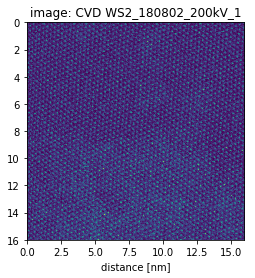

In [2]:
# Load file
#h5_file.close()
h5_file = ft.h5open_file()#os.path.join(current_directory,filename))
current_channel = h5_file['Measurement_000/Channel_000']

ft.plt_pyUSID(current_channel)


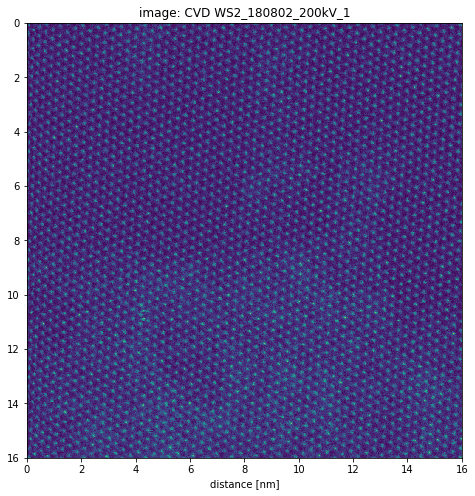

In [3]:
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(1,1,1)
ft.plt_pyUSID(current_channel,ax)

## Fourier Transform of Image

32.0 32.0
0.17911725 0.70840985 5.685115
0.5889852821826934 5.035119080543518


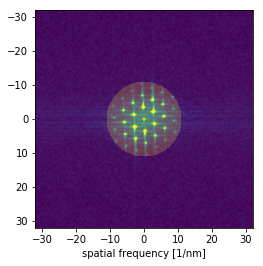

In [25]:
if current_channel['data_type'][()] == 'image':
    ## spatial data
    tags = dict(current_channel.attrs)
    basename = current_channel['title'][()]
    
    sizeX = current_channel['spatial_size_x'][()]
    sizeY = current_channel['spatial_size_y'][()]
    scaleX = current_channel['spatial_scale_x'][()]
    scaleY = current_channel['spatial_scale_y'][()]
    basename = current_channel['title'][()]

    FOV_x = sizeX*scaleX
    FOV_y = sizeY*scaleY
    
    data = np.reshape(current_channel['Raw_Data'][:,0],(sizeX,sizeY))
        
image = data- data.min()
fft_mag = (np.abs((np.fft.fftshift(np.fft.fft2(image)))))

## pixel_size in recipical space
rec_scale_x = 1/FOV_x  
rec_scale_y = 1/FOV_y 

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * sizeX /2.
rec_FOV_y = rec_scale_y * sizeY /2.
print(rec_FOV_x , 1/(scaleX*2))


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

# We need some smoothing (here with a Gaussian)
smoothing = 3
fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)
fft_mag2 = np.log2(1+fft_mag2)


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x
x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

mask_spot = x**2+y**2 > 1**2 
mask = mask + mask_spot
mask_spot = x**2+y**2 < 11**2 
mask = mask + mask_spot

mask[np.where(mask==1)]=0 # just in case of overlapping disks

fft_mag3 = fft_mag2*mask
print(np.std(fft_mag2),np.mean(fft_mag2) ,np.max(fft_mag2) )
#print(np.std(fft_mag2[np.where(mask==2)]),np.mean(fft_mag2[np.where(mask==2)]) ,np.max(fft_mag2[np.where(mask==2)]))


minimum_intensity = fft_mag2[np.where(mask==2)].min()*0.95
#minimum_intensity = np.mean(fft_mag3)-np.std(fft_mag3)
maximum_intensity = fft_mag2[np.where(mask==2)].max()*1.05
#maximum_intensity =  np.mean(fft_mag3)+np.std(fft_mag3)*2

print(minimum_intensity,maximum_intensity)
fig = plt.figure()
plt.imshow(fft_mag2.T, extent=rec_extend, origin = 'upper',vmin=minimum_intensity, vmax=maximum_intensity*.5)
plt.imshow(mask, extent=rec_extend, origin = 'upper',alpha = 0.2)
plt.xlabel('spatial frequency [1/nm]');


## Spot Detection

Found 21 reflections


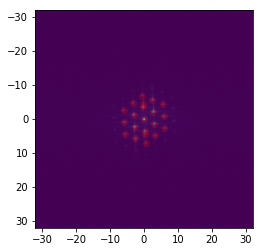

In [36]:
# Input
spot_threshold = 0.02

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(image.shape[0]/2), int(image.shape[1]/2),1] )

fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)
fft_mag2 = fft_mag2-fft_mag2.min()
fft_mag2 = fft_mag2/fft_mag2.max()
## spot detection ( for future referece there is no symmetry assumed here)

spots_random =  (blob_log(fft_mag2,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale
print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
fig = plt.figure()
plt.imshow( np.log2(1+fft_mag2.T), extent=rec_extend, origin = 'upper')#,vmin=minimum_intensity, vmax=maximum_intensity)

#vmin=fft_mag.min()*2.5, vmax=fft_mag.max()*.7)#, extent=(-1024*gx,1023*gx,1024*gy,-1023*gy))

plt.scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.2, label='spots');
fft_mag2 = np.log2(1+fft_mag2)

## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image,the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-path** area in the code below and notice the effects on the Fourier filtered image.



<IPython.core.display.Javascript object>


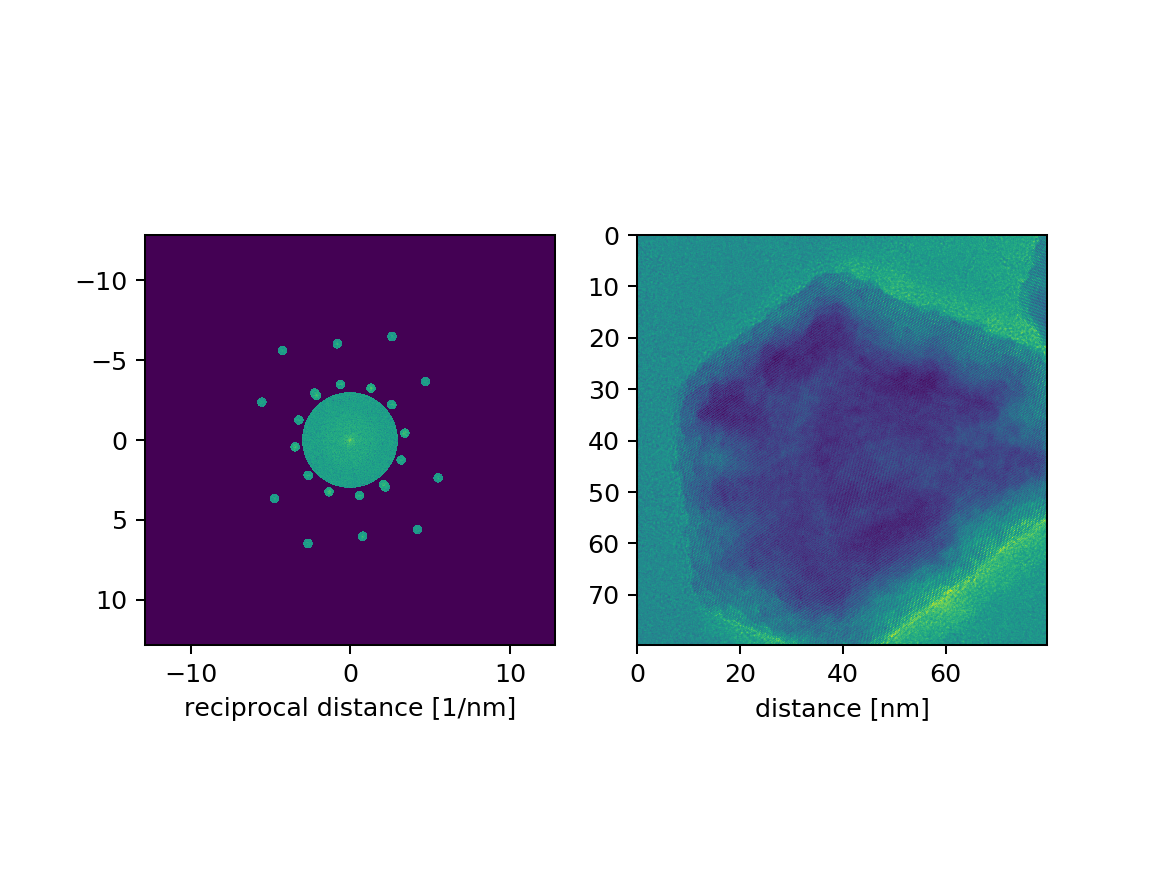

In [17]:
#prepare mask
pixels = (np.linspace(0,2047,2048)-1023.5)* rec_scale_x
x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections
reflection_radius = 0.3 # in 1/nm
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)
low_pass = 3 # in 1/nm
mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot
mask[np.where(mask>1)]=1    

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))
real_extent = (0,FOV_x,FOV_y,0)
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


<IPython.core.display.Javascript object>


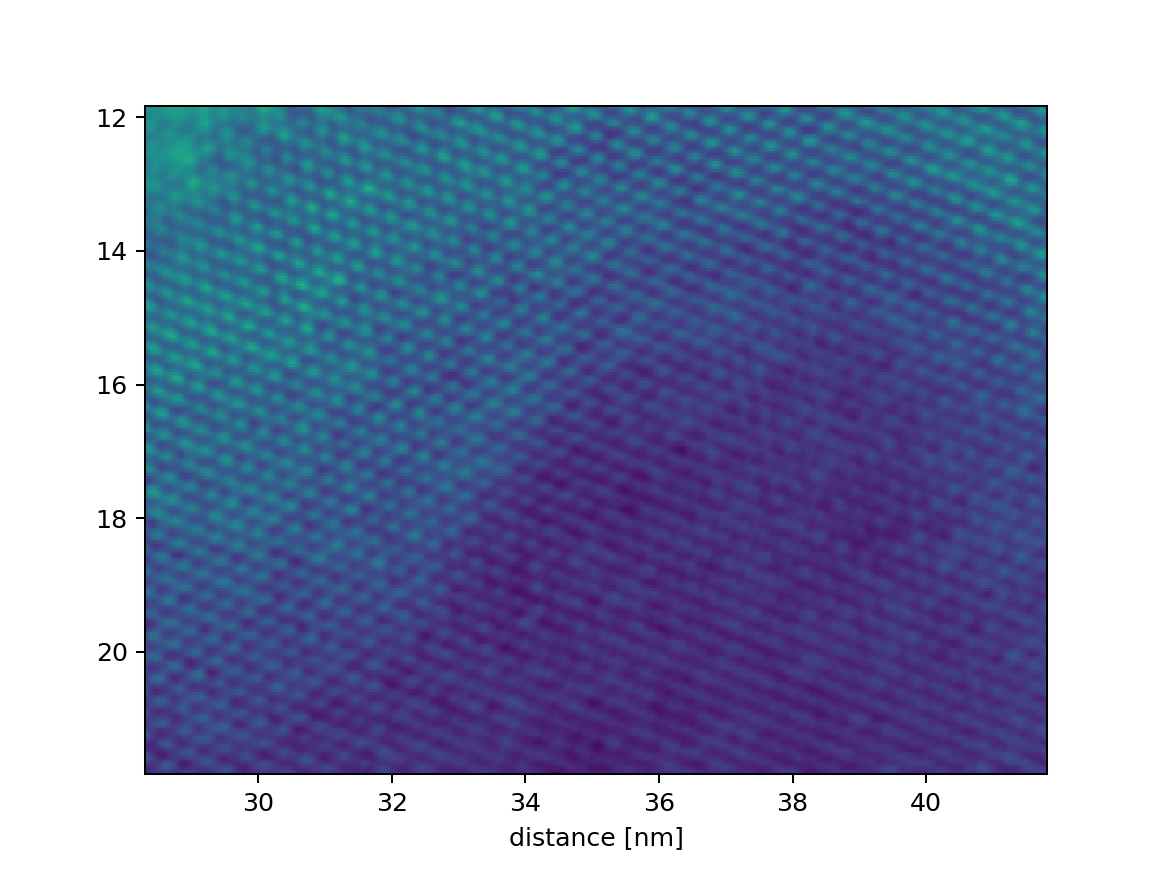

In [19]:

plt.figure()
plt.imshow(filtered.real, extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');

## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


<IPython.core.display.Javascript object>


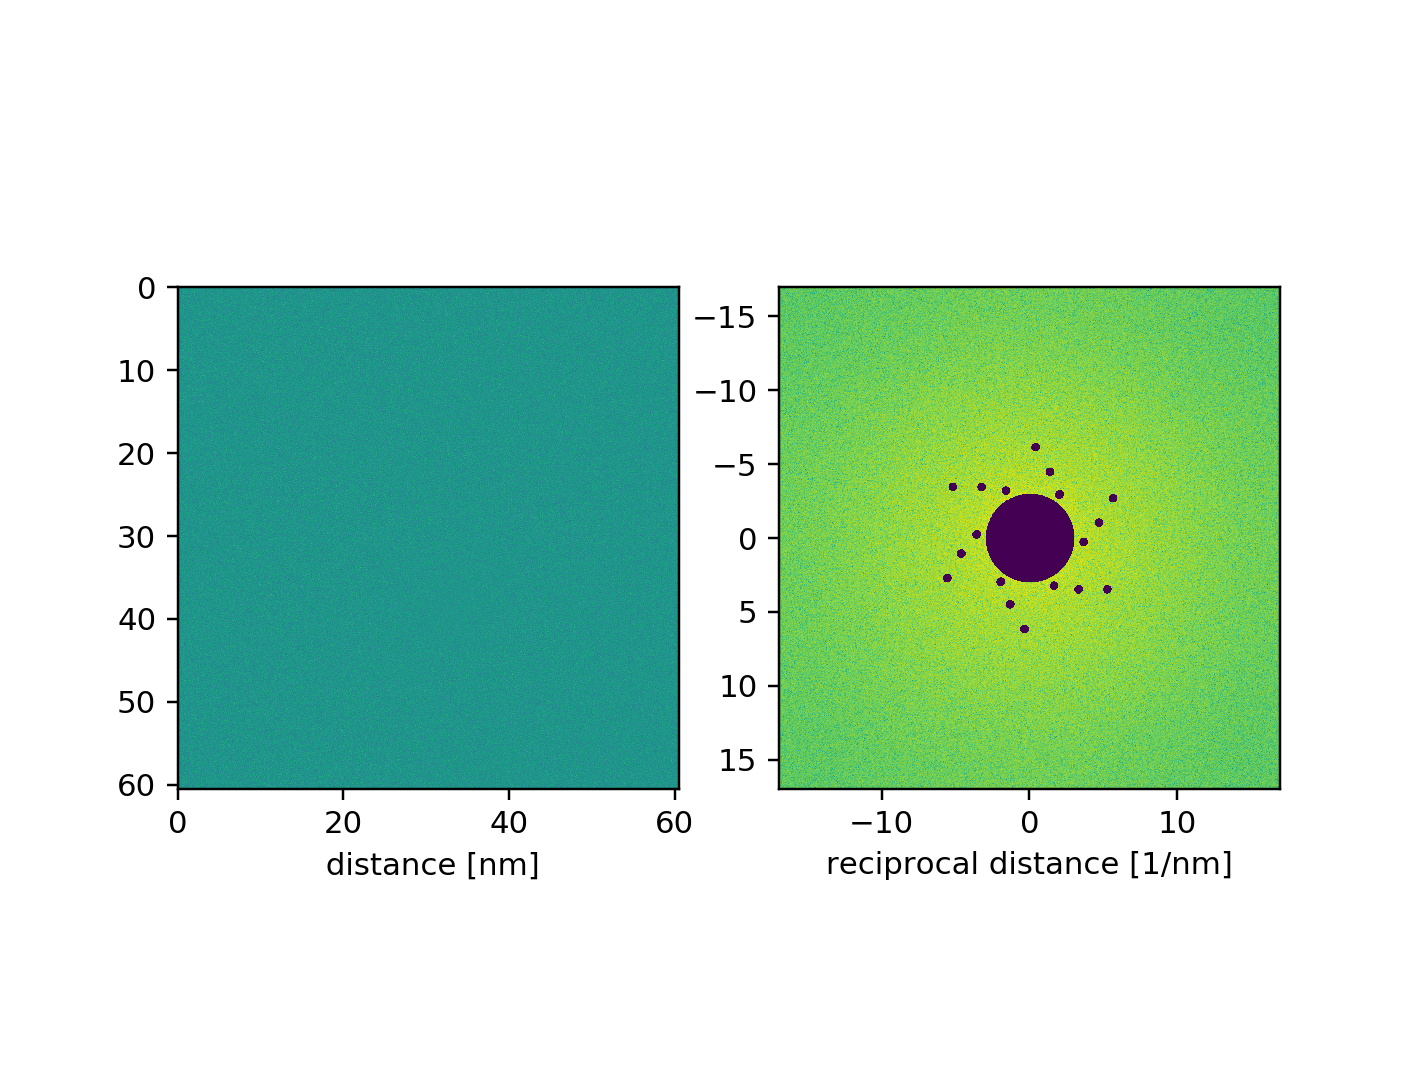

In [7]:
plt.figure()
ax1 = plt.subplot(1,2,1)
ax1.imshow(image-filtered.real,extent=FOV, origin = 'upper')
plt.xlabel(' distance [nm]')

ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered.real))
ax2.imshow(np.log(1+np.abs(fft_difference)).real,extent=rev_FOV, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Rotational Symmetry

In our context of symmetry, we just need to deal with the discrete values of Θ = 2π/n for the angle of rotation.

In two dimensios we have then the rotation matrix:
$$C_{n-fold} = \left[\array{ \cos{( 2\pi/n)} & \sin{( 2\pi/n)}\\ -\sin{( 2\pi/n)} & \cos{ (2\pi/n)}\\}\right]$$

If we subtract all spots from all rotated spots we have a set of distances where for each spot there is minimal distance to the next spot.
If we have a very small distance for each original spot, we have a found rotational symmetry operation.  

In [20]:
from itertools import product

for n in [2,3,4,6]:
    C = np.array([[np.cos(2*np.pi/n), np.sin(2*np.pi/n),0],[-np.sin(2*np.pi/n), np.cos(2*np.pi/n),0], [0,0,1]])
    sym_spots = np.dot(spots,C)
    dif = []
    for p0, p1 in product(sym_spots[:,0:2], spots[:,0:2]):
        dif.append(np.linalg.norm(p0-p1))
    dif = np.array(sorted(dif))
    #print(dif[0:spots.shape[0]])
    if dif[int(spots.shape[0]*.7)] < 0.2:
        
        print(f'Found {n}-fold symmetry in diffraction pattern')
        

Found 2-fold symmetry in diffraction pattern
Found 3-fold symmetry in diffraction pattern
Found 6-fold symmetry in diffraction pattern


## Mirror symmetry

Any mirror axis has to go through the origin.

Let's consider the points as vectors and let's condier the miror axis as a vector field that lays on that axis.

The mirror axis of any point has to go through that point plus the half of the vector to another point.


Reflection across a line through the origin in two dimensions can be described by the following formula
$$\operatorname{Ref}_l(v) = 2\frac{v \cdot l}{l \cdot l}l - v,$$

where $v$ is the vector of a point, while $l$ is a vector on the mirror axis on which $v$ is reflected on. $v \cdot l$ denotes the dot product of $v$ and $l$. 


<IPython.core.display.Javascript object>


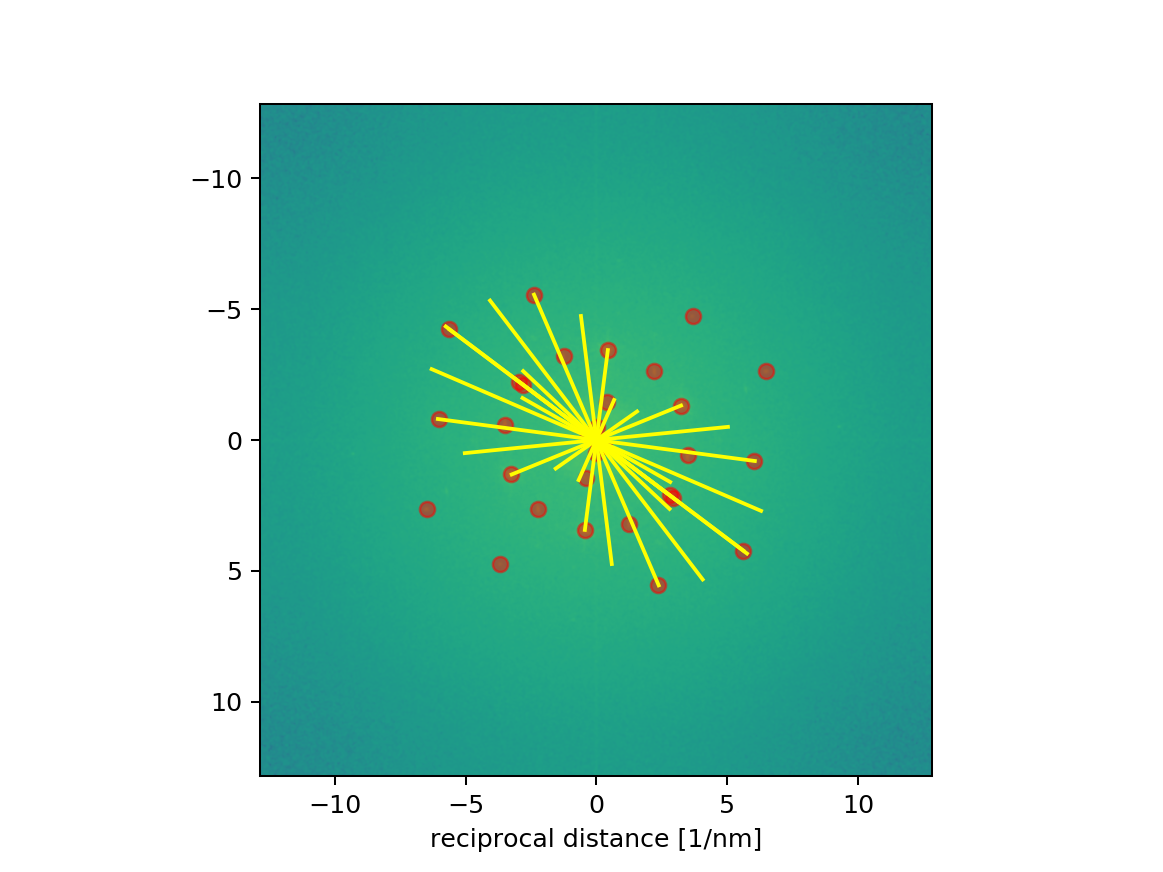

Found mirror [0.79808053 0.6025508 ] axis in diffraction pattern
Found mirror [0.79845196 0.60205853] axis in diffraction pattern
Found mirror [0.86919246 0.49447393] axis in diffraction pattern
Found mirror [0.72800828 0.68556834] axis in diffraction pattern
Found mirror [0.12338848 0.99235844] axis in diffraction pattern
Found mirror [ 0.99506173 -0.09925803] axis in diffraction pattern
Found mirror [ 0.81861115 -0.57434814] axis in diffraction pattern
Found mirror [0.6062687  0.79525987] axis in diffraction pattern
Found mirror [ 0.92623167 -0.37695475] axis in diffraction pattern
Found mirror [0.39416966 0.91903769] axis in diffraction pattern
Found mirror [0.99133512 0.13135704] axis in diffraction pattern
Found mirror [-0.12670768  0.9919401 ] axis in diffraction pattern
Found mirror [0. 1.] axis in diffraction pattern
Found mirror [0.79914296 0.60114102] axis in diffraction pattern
Found mirror [-0.40474711  0.91442866] axis in diffraction pattern
Found mirror [0.9185762  0.3952

In [30]:
mirror_axes = []
plt.figure()
plt.imshow(fft_mag2.T,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.5, label='spots');

for spot in spots:
    if spot[2] > .1:
        mirror_spots = []
        for spot2 in spots:
            if spot2[2]>.1:
                l = spot[0:2]+spot2[0:2]/2
                v = spot[0:2]
                ref = 2*np.dot(v,l) / np.dot(l,l)*l-v
                mirror_spots.append(ref)
        mirror_spots = np.array(mirror_spots)
        dif = []
        for p0, p1 in product(mirror_spots, spots[:,0:2]):
            dif.append(np.linalg.norm(p0-p1))
        dif = np.array(sorted(dif))
        #print(dif[0:25])
        #print(int(spots.shape[0]/2))
        #print(dif[int(spots.shape[0]/2)])
        if dif[int(spots.shape[0]/2)] < 0.5:
            #print(l,dif[0:25])
            mirror_axes.append(l)
            axis=l/np.linalg.norm(l)
            plt.plot([-l[0],l[0]],[-l[1],l[1]],c='yellow')
            print(f'Found mirror {axis} axis in diffraction pattern')
print(f'Found {len(mirror_axes)} mirror axes')


## Reference Crystal

In [24]:
tags_Graphite  = ks.structure_by_name('Graphite')
tags_ZnO = ks.structure_by_name('ZnO')
### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200.0 *1000.0 #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = 30
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices


######################################
# Diffraction Simulation of Graphite #
######################################
tags_Graphite.update(tags_experiment)
ks.Kinematic_Scattering(tags_Graphite, False)

######################################
# Diffraction Simulation of ZnO      #
######################################
tags_ZnO.update(tags_experiment)
ks.Kinematic_Scattering(tags_ZnO, False)



<IPython.core.display.Javascript object>


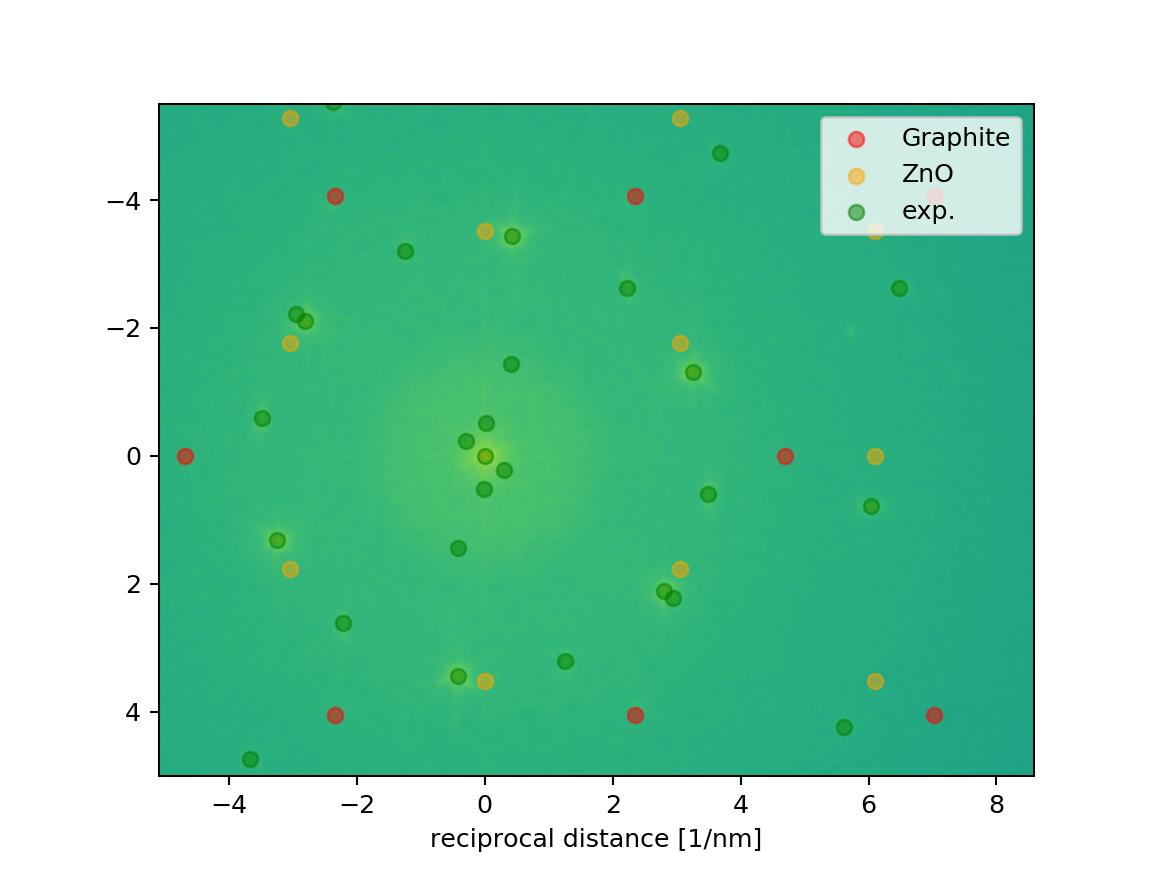

In [31]:

spots_Graphite = tags_Graphite['allowed']['g']
spots_ZnO = tags_ZnO['allowed']['g']

resolution = 0.1#nm

plt.figure()
plt.imshow(fft_mag2.T,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5, label='exp.');

plt.legend(loc=1);

## Reflections in Polar Coordinates 
A more interesting way of comparing a simulation and experiment is to compare the spots in polar coordinates:

conversion to Euclidean space:
$$\begin{align}
  x &= r \cos\varphi \\
  y &= r \sin\varphi
\end{align}$$

conversion to polar coordinates:
$$\begin{align}
r &= \sqrt{x^2 + y^2} \\
\varphi &= \operatorname{atan2}(y, x) 
\end{align}$$

 Rotated Graphite SAD by 7.0°
 Rotated ZnO SAD by -162.2°


<IPython.core.display.Javascript object>


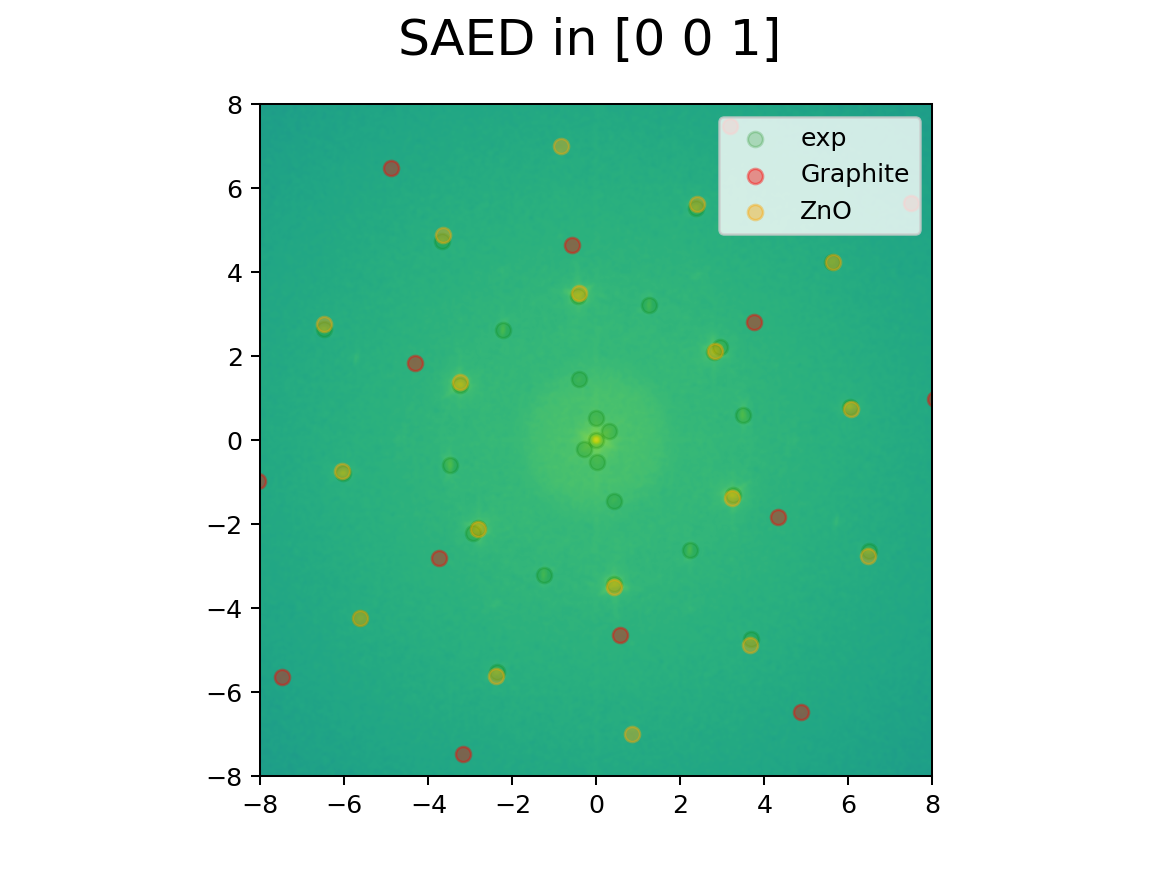

In [32]:
##  Polar Coordinates of experimental and reference lattice

def cart2pol(points):
    rho = np.linalg.norm(points[:,0:2], axis=1)
    phi = np.arctan2(points[:,1], points[:,0])
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def xy2polar(points, rounding = 1e-3):
    """
    Conversion from carthesian to polar coordinates
    
    the angles and distances are sorted by r and then phi
    The indices of this sort is also returned
    
    input points: numpy array with number of points in axis 0 first two elements in axis 1 are x and y
    
    optional rounding in significant digits 
    
    returns r,phi, sorted_indices
    """
    
    r,phi = cart2pol(points)
    
    phi = phi-phi.min() # only positive angles
    r = (np.floor(r/rounding) )*rounding # Remove rounding error differences

    sorted_indices = np.lexsort((phi,r) ) # sort first by r and then by phi
    r = r[sorted_indices]
    phi = phi[sorted_indices]
    
    return r, phi, sorted_indices

## Transfer everything to polar coordinates 
graphite_r, graphite_phi, graphite_indices = xy2polar(spots_Graphite) #sorted by r and phi , only positive angles
ZnO_r, ZnO_phi, ZnO_indices = xy2polar(spots_ZnO)
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_phi[angleI] - graphite_phi[0] ## Determine rotation angle

graphite_phi = graphite_phi + angle # rotation
print(f" Rotated Graphite SAD by {np.degrees(angle):.1f}°")


angleI2 = np.argmin(np.abs(exp_r-ZnO_r[0]) )
angle2 = exp_phi[angleI2] - ZnO_phi[0] ## Determine rotation angle


ZnO_phi = ZnO_phi + angle2 # rotation
print(f" Rotated ZnO SAD by {np.degrees(angle2):.1f}°")


fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_Graphite['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag2.T,extent=rec_extend, origin = 'upper')

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(graphite_r, graphite_phi)
plt.scatter(x,y, c='red',  alpha = 0.4,label='Graphite')

x,y = pol2cart(ZnO_r, ZnO_phi)
plt.scatter(x,y, c='orange',  alpha = 0.4,label='ZnO')



plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


## Calibrate Distortions with Reference Crystal

In [38]:
g = gx = gy = rec_scale_x

spots_reference = np.array(pol2cart(graphite_r, graphite_phi)).T
print(spots_reference[:,0].shape)

spots_experiment =spots[:,0:2]
dist_graphite = np.linalg.norm(spots_reference, axis=1)
print(dist_graphite)

distance_experiment = np.linalg.norm(spots_experiment, axis=1)
print(distance_experiment)
first_reflections = abs(distance_experiment - dist_graphite.min()) < .2
print('Evaluate ', first_reflections.sum(), 'reflections')
reference_reflections = spots_experiment[first_reflections]

import scipy.optimize as optimization
def func(params, xdata, ydata):
    dgx , dgy = params
    return (np.sqrt((xdata*dgx)**2 + (ydata*dgy)**2 ) - dist_graphite.min())

x0 = [1.,0.999]
[dgx, dgy], sig = optimization.leastsq(func, x0, args=(reference_reflections[:,0], reference_reflections[:,1]))

print('distortion x:', dgx, 'y: ', dgy) 
gx /=dgx
gy /=dgy

spots_experiment = spots_experiment*(dgx,dgy)


(22,)
[ 4.686  4.686  4.686  4.686  4.686  4.686  8.116  8.116  8.116  8.116
  8.116  8.116  9.372  9.372  9.372  9.372  9.372  9.372 12.398 12.398
 12.398 12.398]
[0.         0.37611535 0.37611535 0.51417718 0.51417718 1.49996219
 1.49996219 3.43367659 3.43367659 3.44569471 3.44569471 3.46153289
 3.46153289 3.50382175 3.50382175 3.51040995 3.51040995 3.53479514
 3.53479514 3.68844555 3.68844555 5.99603581 5.99603581 6.01525927
 6.01525927 6.08188848 6.08188848 6.99602638 6.99602638 7.0358931
 7.0358931 ]
Evaluate  0 reflections


TypeError: Improper input: N=2 must not exceed M=0

## Plot Corrected Image and Reference Lattice

In [36]:
FOV_cor = (0,FOV_x/dgx,FOV_y/dgy,0)
rev_FOV_cor = (-rev_FOV_x*dgx,rev_FOV_x*dgx,rev_FOV_y*dgy,-rev_FOV_y*dgy)

plt.figure()
plt.title(' Graphite and ZnO in ' + str(tags_Graphite['zone_hkl']), fontsize=20)     

plt.imshow(fft_mag2.T,extent=rev_FOV_cor, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
plt.scatter(spots_Graphite[:,0], spots_Graphite[:,1], c='Red',  alpha = 0.5, label='Graphite');
plt.scatter(spots_ZnO[:,0], spots_ZnO[:,1], c='orange',  alpha = 0.5, label='ZnO');
plt.scatter(spots[:,0]*dgx, spots[:,1]*dgy, c='green',  alpha = 0.5, label='exp.');
\

plt.xlim(-7,7)
plt.ylim(-7,7)
plt.legend(loc=1)


NameError: name 'dgx' is not defined

(22,)
[0.52359878 1.57079633 2.61799388 3.66519143 4.71238898 5.75958653
 0.         1.04719755 2.0943951  3.14159265 4.1887902  5.23598776
 0.52359878 1.57079633 2.61799388 3.66519143 4.71238898 5.75958653
 0.85707195 1.23732315 3.9986646  4.37891581]
106.4999208190518 2.3823730470040085 0.5235987755982987


<IPython.core.display.Javascript object>


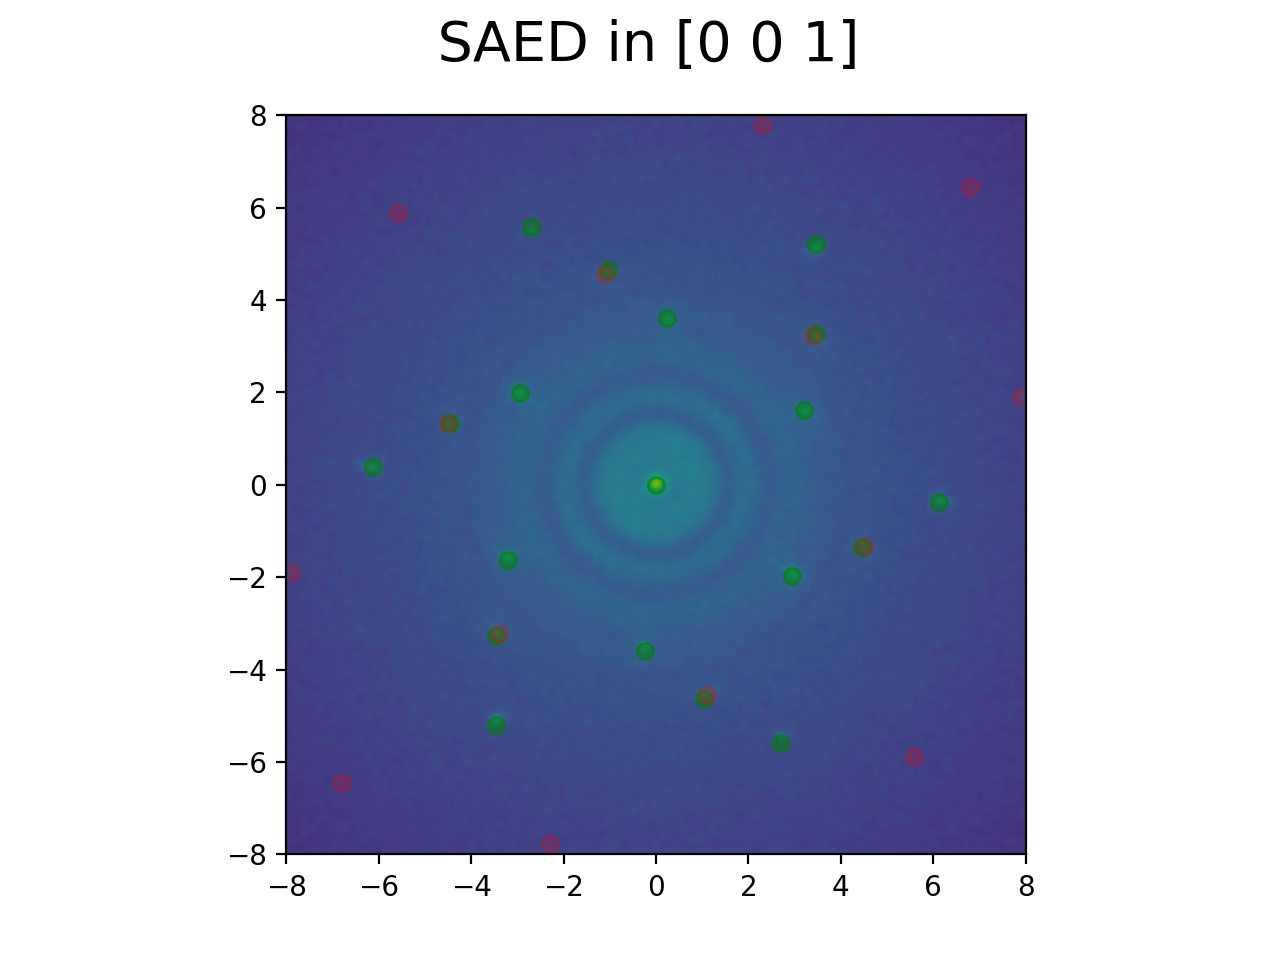

In [160]:
##  Polar Coordinates of experimental and reference lattice

graphite_r = np.linalg.norm(spots_Graphite, axis=1)
graphite_theta = np.arctan2(spots_Graphite[:,1], spots_Graphite[:,0])
print(graphite_r.shape)

graphite_theta = graphite_theta-graphite_theta.min() # only positive angles
graphite_r = (np.floor(graphite_r*1000) )/1000. # Remove rounding error differences

graphite_sorted= np.lexsort((graphite_theta,graphite_r) ) # sort first by r and then by theta
graphite_r = graphite_r[graphite_sorted]
graphite_theta = graphite_theta[graphite_sorted]#-graphite_theta.min() ## lets have all angles positive and sorted
print((graphite_theta))

exp_r = np.linalg.norm(spots[:,0:2], axis=1)
exp_theta = np.arctan2(spots[:,1], spots[:,0])

exp_r = (np.floor(exp_r*100) )/100. # Remove rounding error differences
exp_theta = exp_theta -exp_theta.min()
exp_sorted= np.lexsort((exp_theta,exp_r) ) # sort first by r and then by theta

exp_r = exp_r[exp_sorted]
exp_theta = exp_theta[exp_sorted]

angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_theta[angleI] - graphite_theta[0] 

print(np.degrees(angle), exp_theta[angleI], graphite_theta[0] )

graphite_theta = graphite_theta - angle


p_graphite =  np.dot(tags_Graphite['allowed']['g'][tags_Graphite['allowed']['ZOLZ']],r_mat)

fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_Graphite['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag2.T,extent=rev_FOV_cor, origin = 'upper')

x = np.cos(graphite_theta)* graphite_r
y = np.sin(graphite_theta)* graphite_r


plt.scatter(spots[:,0], spots[:,1], c='green',  alpha = 0.5,
           label='spots')
plt.scatter(x,y, c='red',  alpha = 0.2,
           label='Graphite')
plt.xlim(-8,8);plt.ylim(-8,8)
plt.show()


 Rotated Graphite SAD by -46.7°
 Rotated ZnO SAD by -53.1°


<IPython.core.display.Javascript object>


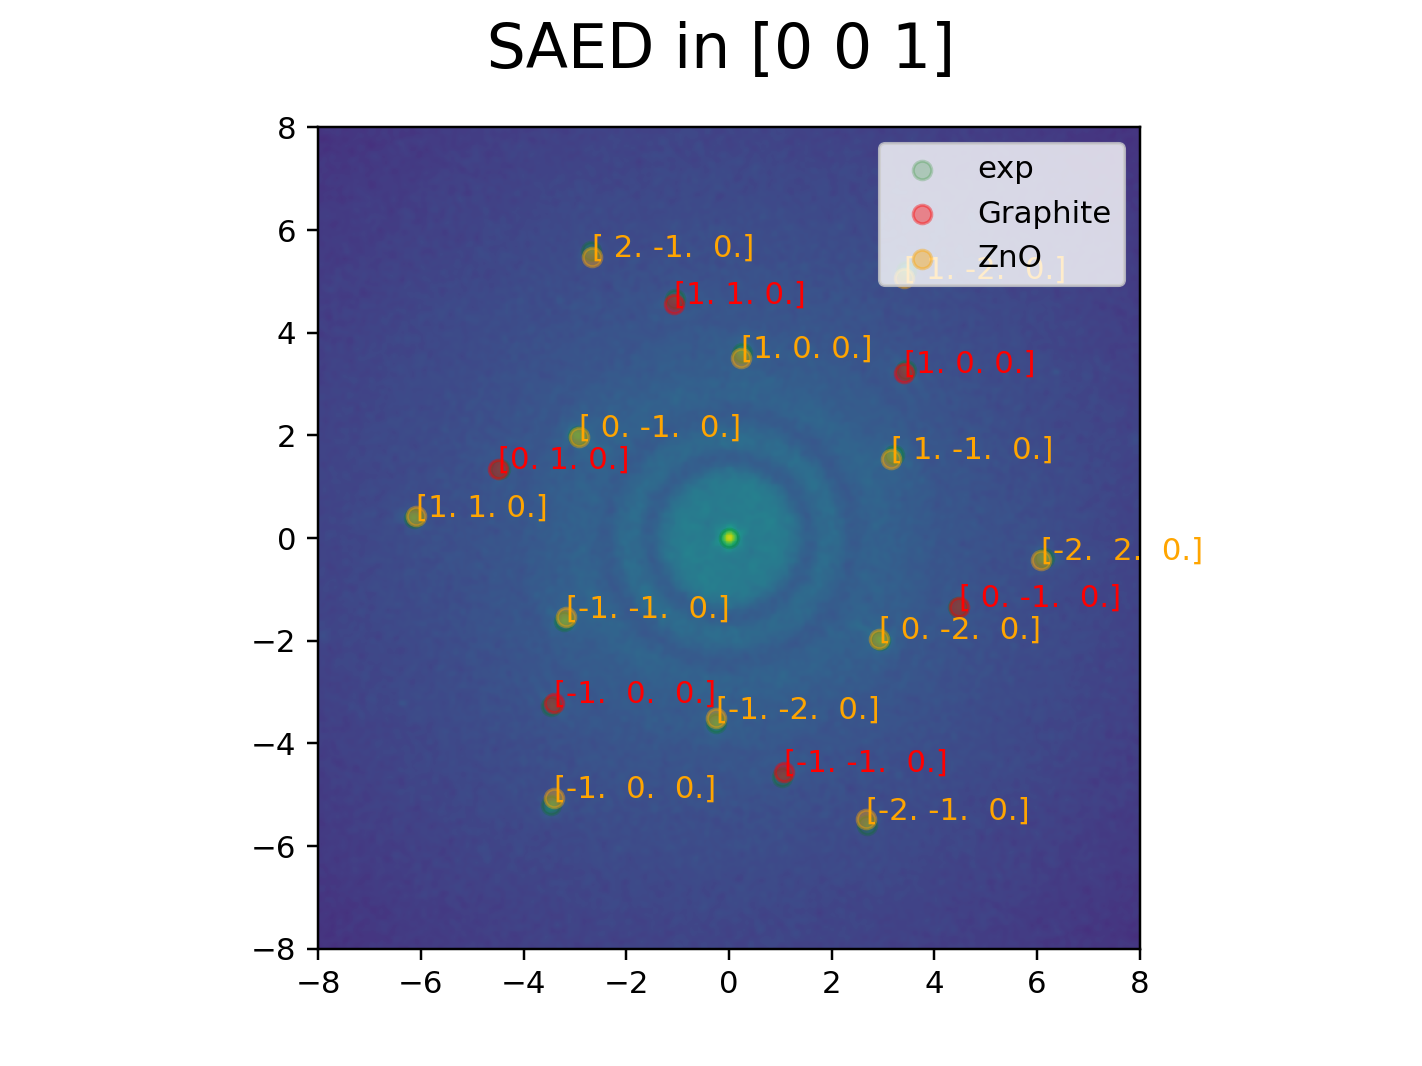

In [19]:
## Transfer everything to polar coordinates 
graphite_r, graphite_phi, graphite_indices = xy2polar(spots_Graphite) #sorted by r and phi , only positive angles
ZnO_r, ZnO_phi, ZnO_indices = xy2polar(spots_ZnO)
exp_r, exp_phi = cart2pol(spots) # just in polar coordinates

resolution = 1/exp_r.max()
visible_Graphite = graphite_r < 1/resolution
visible_ZnO = ZnO_r  < 1/resolution


angleI = np.argmin(np.abs(exp_r-graphite_r[0]) )
angle = exp_phi[angleI] - graphite_phi[0] ## Determine rotation angle

graphite_phi = graphite_phi + angle # rotation
print(f" Rotated Graphite SAD by {np.degrees(angle):.1f}°")


angleI2 = np.argmin(np.abs(exp_r-ZnO_r[0]) )
angle2 = exp_phi[angleI2] - ZnO_phi[0] ## Determine rotation angle


ZnO_phi = ZnO_phi + angle2 # rotation
print(f" Rotated ZnO SAD by {np.degrees(angle2):.1f}°")


fig = plt.figure()
fig.suptitle(' SAED in ' + str(tags_Graphite['zone_hkl']), fontsize=20)     
plt.imshow(fft_mag2.T,extent=rev_FOV, origin = 'upper')

x, y= pol2cart(exp_r, exp_phi)
plt.scatter(x,y, c='green',  alpha = 0.2,label='exp')

x, y= pol2cart(graphite_r[visible_Graphite], graphite_phi[visible_Graphite])
plt.scatter(x,y, c='red',  alpha = 0.4,label='Graphite')

for i in range(len(graphite_r)):
    if visible_Graphite[i]:
        plt.text(x[i],y[i], tags_Graphite['allowed']['hkl'][graphite_indices[i]],color='red')

x,y = pol2cart(ZnO_r[visible_ZnO], ZnO_phi[visible_ZnO])
plt.scatter(x,y, c='orange',  alpha = 0.4,label='ZnO')
for i in range(len(ZnO_r)):
    if visible_ZnO[i]:
        plt.text(x[i],y[i], tags_ZnO['allowed']['hkl'][graphite_indices[i]], color='orange')




plt.xlim(-8,8);plt.ylim(-8,8)
plt.legend(loc=1);


## Plot Histograms of Distances

In [20]:
from scipy.interpolate import interp1d
from scipy.ndimage import map_coordinates


def cartesian2polar(x, y, grid, r, t, order=3):

    R,T = np.meshgrid(r, t)

    new_x = R*np.cos(T)
    new_y = R*np.sin(T)

    ix = interp1d(x, np.arange(len(x)))
    iy = interp1d(y, np.arange(len(y)))

    new_ix = ix(new_x.ravel())
    new_iy = iy(new_y.ravel())

    
    return map_coordinates(grid, np.array([new_ix, new_iy]),
                            order=order).reshape(new_x.shape)

def warp(diff):
    # Define original polar grid
    nx = diff.shape[0]
    ny = diff.shape[1]

    x = np.linspace(1, nx, nx, endpoint = True)-center[1]
    y = np.linspace(1, ny, ny, endpoint = True)-center[0]
    z = diff

    # Define new polar grid
    nr = min([center[0], center[1], diff.shape[0]-center[0], diff.shape[1]-center[1]])-1
    nt = 360*3


    r = np.linspace(1, nr, nr)
    t = np.linspace(0., np.pi, nt, endpoint = False)
    return cartesian2polar(x,y, z, r, t, order=3).T

Scherzer defocus is -85.8 nm


<IPython.core.display.Javascript object>


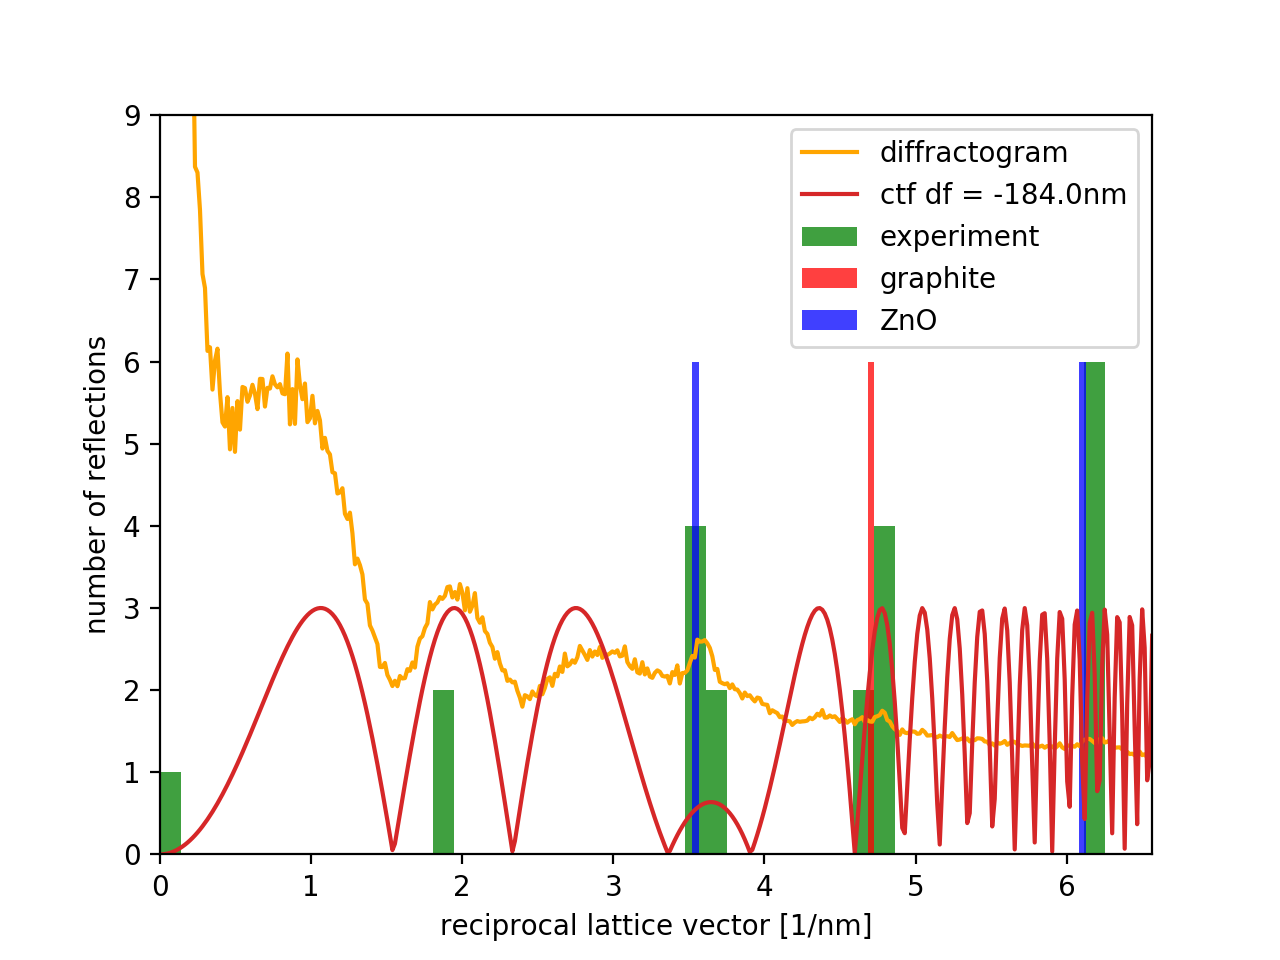

In [18]:
polar_projection = warp(fft_mag)
below_zero = polar_projection<0.
polar_projection[below_zero]=0.

# Sum over all angles (axis 1)
profile = polar_projection.sum(axis=1)


k =np.linspace(1,len(profile),len(profile))*rev_scale_x

Cs = 2.2
defocus = -184 # underfocus is negative
waveLength = ks.get_waveLength(200*1e3) # in nm
def calculateScherzer(waveLength, Cs):
    # Calculate the Scherzer defocus. Cs is in mm, lambda is in nm
    # Everything is trasnfered to m
    #The returned value is in nm
    Cs=Cs*1e-3 # now in m
    scherzer=-1.155*(Cs*waveLength*1e-9)**0.5 # in m
    scherzer=scherzer*1e9 # convert to nm
    return scherzer

scherzer =calculateScherzer(waveLength, Cs)

print(f'Scherzer defocus is {scherzer:.1f} nm')

def calculateCTF(waveLength, Cs, defocus,k3):
    # everything in nm
    Cs=Cs*10**6
    ctf=np.sin(np.pi*defocus*waveLength*k**2+0.5*np.pi*Cs*waveLength**3*k**4)
    return ctf
ctf = calculateCTF(waveLength, Cs, defocus,k)


fig = plt.figure()
plt.hist(exp_r,45,facecolor='green', alpha=0.75, label='experiment')
plt.hist(graphite_r,200,facecolor='red', alpha=0.75, label='graphite')
plt.xlim(0,exp_r.max()*1.05)

plt.hist(ZnO_r,200,facecolor='blue', alpha=0.75, label='ZnO')
plt.plot(k,profile/profile.max()*5000,c='orange',label='diffractogram' );
plt.plot(k,np.abs(ctf)*3, label = f'ctf df = {defocus:.1f}nm')
#plt.hist(np.linalg.norm(p_ZnO, axis=1),200,facecolor='orange', alpha=0.75, label='hexagonal ZnO')
plt.legend()
plt.xlabel('reciprocal lattice vector [1/nm]')
plt.ylabel('number of reflections')

plt.ylim(0,9)

plt.show()

## Another Image
Go back to [Load an atomic resolution image](#Load-an-atomic-resolution-image)

Try the same procedure with image **p1-hr4-ZnOonGraphite.dm3** in the TEMdata directory, which is taken with a different defocus (which one?)

In [21]:
# The x and y size of the image are stored in the 'axis' keyword of the dicyionary
print(image_tags['axis'].keys())
print(image_tags['axis']['0'])

# The scale has to be recalculated
dx = image_tags['axis']['0']['scale']/ dgx
dy = image_tags['axis']['1']['scale']/ dgy

print(f"pixel size x: {dx*1000:.2f}pm, y: {dy*1000.:.2f}pm , nominal {image_tags['pixel_size']*1000:.2f}pm")

print('error x:{0:.2f}%, y:{1:.2f}%'.format(abs(dx- image_tags['pixel_size'] )/image_tags['pixel_size']*100,
                                    abs(dy- image_tags['pixel_size'] )/image_tags['pixel_size']*100))

dict_keys(['0', '1'])
{'origin': 0.0, 'scale': 0.0295258816331625, 'units': 'nm', 'pixels': 2048}
pixel size x: 29.45pm, y: 30.14pm , nominal 29.53pm
error x:0.27%, y:2.09%


## Conclusion:
We see that we can calibrate an image with sub pm precission if the lattice of a reference crystal is resolved.
The original image scale and distortion was accurate within less than 2%. A quite respectable result, if one takes into account that the objective stigmators and the objecitve focus vary from image to image. These electron optic values will change the magnification of course. 

## Back: [Contrast Transfer Function](CTF.ipynb)
## Next: [Image Analysis2](ImageAnalysis3.ipynb)
## Chapter 3: [Imaging](Imaging.ipynb)
## List of Content: [Front](_MSE672-IntroToTEM.ipynb)